In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('../data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df

#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            inputdf[f'{feature}+{i}'] = inputdf[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            inputdf[f'{feature}-{i}'] = inputdf[f'{feature}'].shift(i)   
    inputdf.dropna(inplace=True)
    return inputdf
  
#Use the function
fetures_shift = ['TOC','TN','TP','SS','Rain']
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,0)
df_chunks = adding_remaining_features(df_chunks)

In [2]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

fetures_drop = ['TOC','TN','TP','SS']
X, y = split_dataset(df_chunks,fetures_drop,6)

In [3]:
X.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'Rain+1', 'Rain+2',
       'Rain+3', 'Rain+4', 'Rain+5', 'Rain+6', 'sine', 'cosine', 'is_weekend',
       'logTOC', 'logTN', 'logTP', 'logSS'],
      dtype='object')

In [4]:
y.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [5]:
X_train = X[:20000]
X_test = X[20000:26683]
y_train = y[:20000]
y_test = y[20000:26683]

In [6]:
y_test.shape

(6683, 24)

In [7]:
X_train.shape

(20000, 20)

In [8]:
def create_dataset(X, y, time_steps=1, future = 0):
    Xs, ys = [], []
        
        
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps + future])
    return np.array(Xs), np.array(ys)
# above formats the data for a lstm so that we predict to the next timestep

timesteps = 24

X_train, y_train = create_dataset(X_train,y_train, time_steps= timesteps)
X_test, y_test_lstm = create_dataset(X_test,y_test, time_steps= timesteps)

In [9]:
X_train.shape

(19976, 24, 20)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 87254.7188 - val_loss: 5020.2471
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 4378.9771 - val_loss: 2440.2668
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3515.0732 - val_loss: 2398.0771
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3120.2502 - val_loss: 3402.3530
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2972.8105 - val_loss: 1846.6776
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2345.9604 - val_loss: 932.1053
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1416.2444 - val_loss: 923.5824
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1370.0358 - val_loss: 955.7742
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1381.7251 - val_loss: 934.7157
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1393.6984 - val_loss: 870.5516
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1387.8049 - val_loss: 

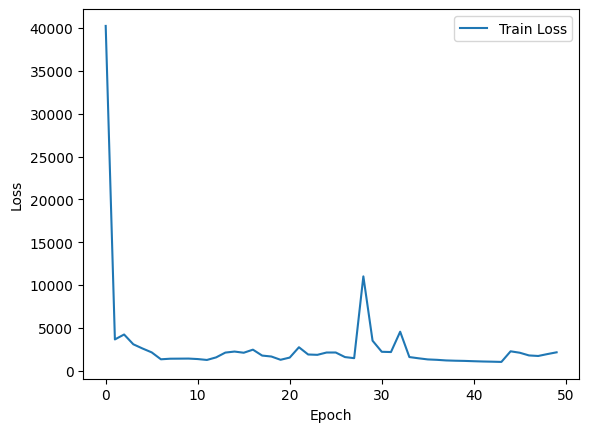

In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Reshape input data for LSTM
# X_train = np.reshape(X_train, (X_train.shape[0], 10, 5))
# X_test = np.reshape(X_test, (X_test.shape[0], 10, 5))

# Build LSTM model
lstm_model = Sequential()
#lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu', kernel_regularizer=l2(0.01)))
lstm_model.add(LSTM(64, input_shape=(24, 20), activation='relu', kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.05))
lstm_model.add(Dense(24, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and get history
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test_lstm))


# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()



In [14]:
# Make predictions
lstm_y_pred = lstm_model.predict(X_test)

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [15]:
dflstm_y_pred = pd.DataFrame(lstm_y_pred, columns=y.columns)
dflstm_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,161.168808,159.881317,159.635437,157.905960,155.673447,152.705292,41.508034,41.648163,42.579109,42.551041,...,12.063271,12.363188,11.832807,11.910248,0.685938,0.708785,0.692477,0.597950,0.673613,0.640538
1,156.147278,154.978226,154.681732,153.069412,150.822800,147.880661,40.481842,40.586906,41.529762,41.538387,...,11.928600,12.281735,11.720345,11.811735,0.718812,0.746908,0.677767,0.532977,0.708474,0.596699
2,161.652328,160.455322,160.115326,158.549393,156.161026,152.806107,41.424583,41.531174,42.549534,42.581642,...,11.753555,12.108303,11.556855,11.669522,0.716951,0.750504,0.695231,0.579885,0.653185,0.617560
3,143.464722,142.430038,142.561920,141.355469,139.602463,136.156189,37.586346,37.813602,38.933189,38.989059,...,10.985434,11.299766,10.813370,10.876533,0.647045,0.669998,0.678546,0.576929,0.645902,0.632589
4,142.255280,141.345795,141.420898,140.419403,138.626495,135.046402,37.276913,37.474438,38.583858,38.653023,...,10.413357,10.722997,10.257578,10.307964,0.650325,0.670837,0.682046,0.588012,0.652184,0.638990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6654,21.895182,20.967163,21.718559,21.815060,21.750927,21.504126,12.452230,12.078146,12.356355,12.218491,...,3.905595,3.998721,3.893976,3.825725,0.430109,0.422627,0.489414,0.458079,0.472377,0.478298
6655,21.769793,20.832518,21.580048,21.672607,21.603729,21.377514,12.410495,12.030110,12.299347,12.157837,...,3.903503,3.993794,3.892254,3.822859,0.429560,0.422375,0.488954,0.458892,0.471864,0.476917
6656,21.909378,20.962822,21.702360,21.801672,21.729546,21.515572,12.456805,12.061954,12.323224,12.176449,...,3.898437,3.988652,3.886024,3.814897,0.427863,0.420555,0.488320,0.458610,0.471223,0.475430
6657,22.429487,21.504860,22.237703,22.334557,22.268486,22.057232,12.589870,12.209561,12.478325,12.335051,...,3.935388,4.023436,3.919765,3.846955,0.426161,0.418878,0.487875,0.461998,0.472657,0.478694


In [16]:
X_train

array([[[7.45541667e+01, 2.93675519e+01, 3.21992712e+00, ...,
         8.03066662e-02, 4.49245047e-02, 3.01935870e-01],
        [6.82395833e+01, 2.41295832e+01, 2.86365625e+00, ...,
         6.64476936e-02, 4.00519526e-02, 3.27912540e-01],
        [6.83052083e+01, 2.44485939e+01, 2.76747918e+00, ...,
         6.72972688e-02, 3.87325034e-02, 3.60678051e-01],
        ...,
        [1.14335417e+02, 3.32959371e+01, 1.54774374e+01, ...,
         9.05760496e-02, 1.99560110e-01, 4.37080626e-01],
        [1.08518750e+02, 3.39802599e+01, 1.16911666e+01, ...,
         9.23542350e-02, 1.54294854e-01, 4.63277322e-01],
        [1.01187500e+02, 3.05761456e+01, 1.00364688e+01, ...,
         8.34773563e-02, 1.33850653e-01, 4.84758463e-01]],

       [[6.82395833e+01, 2.41295832e+01, 2.86365625e+00, ...,
         6.64476936e-02, 4.00519526e-02, 3.27912540e-01],
        [6.83052083e+01, 2.44485939e+01, 2.76747918e+00, ...,
         6.72972688e-02, 3.87325034e-02, 3.60678051e-01],
        [6.07156250e+01, 

In [ ]:
X_train.shape

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, return_sequences=True,input_shape=[]),
#     tf.keras.layers.Dense(14)
# ])

# Reshape input data for LSTM
# X_train = np.reshape(X_train, (X_train.shape[0], 10, 5))
# X_test = np.reshape(X_test, (X_test.shape[0], 10, 5))

# def create_dataset(X, y, time_steps=1, future = 0):
#     Xs, ys = [], []
        
        
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps + future])
#     return np.array(Xs), np.array(ys)
# # above formats the data for a lstm so that we predict to the next timestep

# X_train, y_train = create_dataset(X_train,y_train, time_steps= 25)
# X_test, y_test = create_dataset(X_test,y_test, time_steps= 25)


es_callback = EarlyStopping(monitor='val_loss', patience=2)

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out1 = LSTM(128, return_sequences=False)(inputs)
dropout1 = Dropout(0.30)(lstm_out1)
outputs = Dense(24)(dropout1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')



## checkpoints # name your model here:
checkpoint_path = "../models/1_layer_128_logging_y.keras"
model_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True)

## print visible paths
if False: #os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
else:
    history = model.fit(X_train, y_train, epochs=50, batch_size=12, validation_split=0.2, shuffle=False, callbacks=[es_callback, model_checkpoint_callback])

In [ ]:
# Make predictions
lstm_y_pred = model.predict(X_test)

In [ ]:
dflstm_y_pred = pd.DataFrame(lstm_y_pred, columns=y.columns)
dflstm_y_pred

## Compare the outputs to orginals

In [17]:
y_test = y_test[:len(y_test)-timesteps]

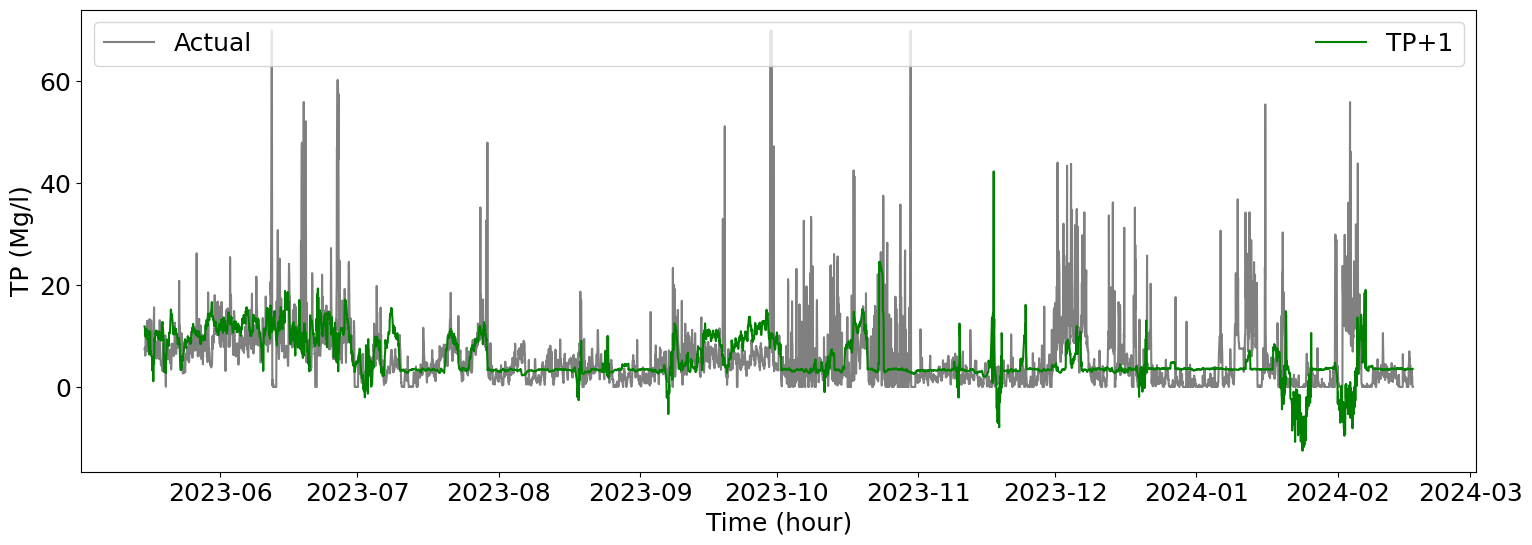

In [21]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'TP'
forcastlength = 1
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,y_test[TS], color = 'gray', label = 'Actual')
plt.plot(time,dflstm_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.line(dflstm_y_pred, x=dflstm_y_pred.index, y=TS)
fig.add_scatter(x=dflstm_y_pred.index, y=y_test[TS]) # No

# # Show plot 
fig.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = r2_score(y_test[index], dflstm_y_pred[index]) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: -0.29749999028966956
TOC+2: -0.3090679129625087
TOC+3: -0.2907879910815796
TOC+4: -0.27973429672335937
TOC+5: -0.2787311816921465
TOC+6: -0.31119699811783796
--------------------------
TN+1: 0.23813098588103976
TN+2: 0.230076489197789
TN+3: 0.2780687955534109
TN+4: 0.2839616187107935
TN+5: 0.2724609579803833
TN+6: 0.299384480614001
--------------------------
TP+1: -0.04499331787923766
TP+2: -0.02712631892349804
TP+3: -0.0180470703022515
TP+4: -0.013125854699213901
TP+5: 6.361332525106622e-05
TP+6: -0.002054090678901277
--------------------------
SS+1: 0.007788888584565834
SS+2: -0.011466733938118034
SS+3: -0.005842859442351633
SS+4: -0.05877052711684638
SS+5: -0.0565983757938997
SS+6: -0.04682701577523796
--------------------------


In [ ]:
y_test[:6658]